In [2]:
import sys

sys.argv = ['']
sys.path.append("../..")
from src.grid_world import GridWorld
from examples.agent import Agent
import numpy as np

In [5]:
class QLearning_On_Policy(Agent):
    def __init__(self, env, num_episodes=5000, episode_length=1000,
                 gamma=0.9, alpha=0.1, epsilon=0.1):
        """
        Sarsa (on-policy TD control)
        """
        super().__init__(
            env=env,
            epsilon=epsilon,
            gamma=gamma,
            num_episodes=num_episodes,
            episode_length=episode_length
        )
        self.alpha = alpha

    def run(self):
        for episode in range(self.num_episodes):
            self.env.reset()
            s0 = self.env.start_state
            st = s0
            while st != self.env.target_state:
                at_idx = self.choose_action(self.state2idx(st))
                at = self.idx2action(at_idx)
                s_next, reward, done, _ = self.env.step(at)

                # Q-Learning update the (st, at) pair
                st_idx = self.state2idx(st)
                at_idx = self.action2idx(at)
                s_next_idx = self.state2idx(s_next)

                TD_target = reward + self.gamma * np.max(self.Q[s_next_idx])
                TD_error = self.Q[st_idx, at_idx] - TD_target

                self.Q[st_idx, at_idx] -= TD_error * self.alpha

                # Q-Learning update the policy
                self.update_policy(st_idx)

                st = s_next

            if (episode + 1) % 500 == 0:
                print(f"Episode {episode + 1} finished.")

    def update_policy(self, st_idx):
        """
        Update policy using epsilon-greedy strategy.
        """
        greedy_action = np.argmax(self.Q[st_idx, :])
        for a in range(self.num_actions):
            if a == greedy_action:
                self.policy[st_idx, a] = 1 - self.epsilon + (self.epsilon / self.num_actions)
            else:
                self.policy[st_idx, a] = self.epsilon / self.num_actions


Episode 500 finished.
Episode 1000 finished.
Episode 1500 finished.
Episode 2000 finished.
Episode 2500 finished.
Episode 3000 finished.
Episode 3500 finished.
Episode 4000 finished.
Episode 4500 finished.
Episode 5000 finished.


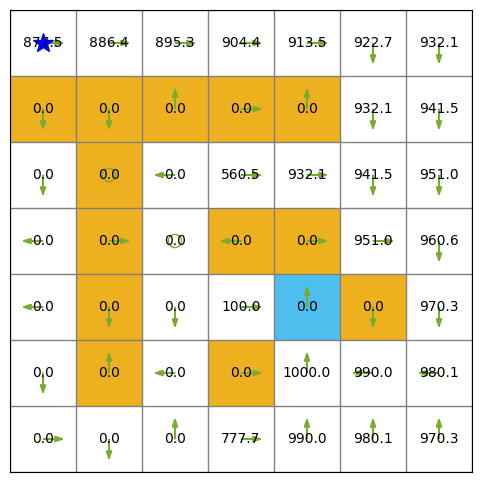

Final Policy:
[[0.04 0.84 0.04 0.04 0.04]
 [0.04 0.84 0.04 0.04 0.04]
 [0.04 0.84 0.04 0.04 0.04]
 [0.04 0.84 0.04 0.04 0.04]
 [0.04 0.84 0.04 0.04 0.04]
 [0.84 0.04 0.04 0.04 0.04]
 [0.84 0.04 0.04 0.04 0.04]
 [0.2  0.2  0.2  0.2  0.2 ]
 [0.2  0.2  0.2  0.2  0.2 ]
 [0.2  0.2  0.2  0.2  0.2 ]
 [0.2  0.2  0.2  0.2  0.2 ]
 [0.2  0.2  0.2  0.2  0.2 ]
 [0.84 0.04 0.04 0.04 0.04]
 [0.84 0.04 0.04 0.04 0.04]
 [0.2  0.2  0.2  0.2  0.2 ]
 [0.2  0.2  0.2  0.2  0.2 ]
 [0.84 0.04 0.04 0.04 0.04]
 [0.04 0.84 0.04 0.04 0.04]
 [0.04 0.84 0.04 0.04 0.04]
 [0.84 0.04 0.04 0.04 0.04]
 [0.84 0.04 0.04 0.04 0.04]
 [0.2  0.2  0.2  0.2  0.2 ]
 [0.2  0.2  0.2  0.2  0.2 ]
 [0.84 0.04 0.04 0.04 0.04]
 [0.2  0.2  0.2  0.2  0.2 ]
 [0.2  0.2  0.2  0.2  0.2 ]
 [0.04 0.84 0.04 0.04 0.04]
 [0.84 0.04 0.04 0.04 0.04]
 [0.2  0.2  0.2  0.2  0.2 ]
 [0.2  0.2  0.2  0.2  0.2 ]
 [0.84 0.04 0.04 0.04 0.04]
 [0.04 0.84 0.04 0.04 0.04]
 [0.2  0.2  0.2  0.2  0.2 ]
 [0.2  0.2  0.2  0.2  0.2 ]
 [0.84 0.04 0.04 0.04 0.04]
 [0.2 

In [6]:
env = GridWorld()
env.reward_step = 0
env.reward_target = 1000
agent = QLearning_On_Policy(env, epsilon=0.2, gamma=0.99, num_episodes=5000, episode_length=1000)
agent.run()
agent.render_static()
print("Final Policy:")
print(agent.get_policy())


In [15]:
class QLearning_Off_Policy(Agent):
    def __init__(self, env, num_episodes=5000, episode_length=1000,
                 gamma=0.9, alpha=0.1, epsilon=0.1):
        """
        Sarsa (on-policy TD control)
        """
        super().__init__(
            env=env,
            epsilon=epsilon,
            gamma=gamma,
            num_episodes=num_episodes,
            episode_length=episode_length
        )
        self.alpha = alpha
        self.target_policy = np.zeros_like(self.policy)
        # policy: behavior policy
        # target_policy: target policy

    def run(self):
        for episode in range(self.num_episodes):
            self.env.reset()
            episodes_list = self.generate_episode()
            for t in range(len(episodes_list) - 1):
                # Update Q value for (st, at)
                st, at, reward = episodes_list[t]
                st_idx = self.state2idx(st)
                at_idx = self.action2idx(at)
                s_next = episodes_list[t + 1][0]
                s_next_idx = self.state2idx(s_next)

                TD_target = reward + self.gamma * np.max(self.Q[s_next_idx])
                TD_error = self.Q[st_idx, at_idx] - TD_target

                self.Q[st_idx, at_idx] -= TD_error * self.alpha

                # Q-Learning update the policy
                self.update_policy(st_idx)

            if (episode + 1) % 500 == 0:
                print(f"Episode {episode + 1} finished.")

    def get_deterministic_policy(self):
        deterministic_policy = np.zeros_like(self.target_policy)
        for s_idx in range(self.num_states):
            max_q = np.max(self.Q[s_idx])
            best_actions = np.where(self.Q[s_idx] == max_q)[0]
            # 随机选一个最优动作（如果有多个）
            best_action = np.random.choice(best_actions)
            deterministic_policy[s_idx, best_action] = 1.0  # 最优动作概率为1，其余为0
        return deterministic_policy

    def update_policy(self, st_idx):
        """
        Update policy using epsilon-greedy strategy.
        """
        greedy_action = np.argmax(self.Q[st_idx, :])
        for a in range(self.num_actions):
            if a == greedy_action:
                self.target_policy[st_idx, a] = 1 - self.epsilon + (self.epsilon / self.num_actions)
            else:
                self.target_policy[st_idx, a] = self.epsilon / self.num_actions

Episode 500 finished.
Episode 1000 finished.
Episode 1500 finished.
Episode 2000 finished.
Episode 2500 finished.
Episode 3000 finished.
Episode 3500 finished.
Episode 4000 finished.
Episode 4500 finished.
Episode 5000 finished.


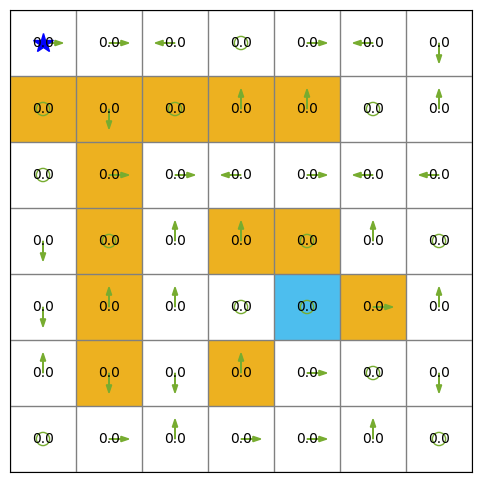

Final Policy:
[[0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.

In [16]:
env = GridWorld()
env.reward_step = 0
env.reward_target = 1000
agent = QLearning_Off_Policy(env, epsilon=0.2, gamma=0.99, num_episodes=5000, episode_length=1000)
agent.run()
agent.render_static()
print("Final Policy:")
print(agent.get_policy())


off policy 的 Qlearning 真的能收敛吗...

明天再看吧